# Creating Clusters and EDA

In this noteboook, We will be examining our data and forming clusters (groups) through Longitude and Latitude of both restaurants and properties. KMeans is the clustering algorithm that will be used in this notebook.

We will use unsupervised learning to create 103 "neighborhoods" to compare against our 103 zipcodes that we collected data from. 

Unsupervised learning is a techinique that we use when there is no target that our model is using to evaluate against. This contrasts with Supervised learning where we have a model that learns and trains on one portion of the data and is tested against data it has not seen.

Ultimately, the purpose for this exercise is to transfer these clusters into a Supervised model and compare the results against the models that used zipcodes as groups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_distances
import hdbscan

np.random.seed(42)

%matplotlib inline

**Importing Data**

In [2]:
yelp_df = pd.read_csv('./data/yelp_combined.csv', index_col =0)

In [3]:
property_df = pd.read_csv('./data/property_df_cleaned.csv', index_col =0)

### Examining Restaurant Data

In [4]:
yelp_df.head()

,name,id,price,alias,type,category,rating,zip,latitude,longitude
0,The Crawfish Co,9fEG4fIAc1DgrghJ2Bo2Vw,2.0,the-crawfish-co-sylmar-3,cajun,cajun,4.5,91342,34.3103,-118.429
1,Truman House Tavern,fe7WfjLwWsfFdvuJ2lhDxg,2.0,truman-house-tavern-san-fernando-2,gastropubs,gastropubs,4.5,91340,34.2819,-118.440
2,Ranch Side Cafe,fzLtFDsHZSuDC36Tlw_3DQ,2.0,ranch-side-cafe-sylmar,tradamerican,tradamerican,4.0,91342,34.2763,-118.379
3,Hide Away Cafe Mexican Grill,CjBiw0DusS7ymVZcq8BTeA,1.0,hide-away-cafe-mexican-grill-los-angeles-2,mexican,mexican,4.5,91342,34.2821,-118.373
4,Villa Terraza,jx-Ptpw7tNvLPnP97N6HBQ,2.0,villa-terraza-shadow-hills,italian,italian,4.5,91040,34.2531,-118.346


We have 30,000 restaurants and 129,000 homes

In [5]:
yelp_df.shape

(30162, 10)

In [6]:
property_df.head()

,property_id,address,zip,year_reassessed,value,latitude,longitude,county_cluster,cluster,labels_km
0,2872021039,18501 CALLE VISTA CIR LOS ANGELES CA 91326,91326,2017,1288400.0,34.2853,-118.535,2102,-1,20
1,2872021038,18500 CALLE VISTA CIR LOS ANGELES CA 91326,91326,2011,619286.0,34.2849,-118.534,2102,-1,20
2,2872021017,18504 ENTRADA CT LOS ANGELES CA 91326,91326,2012,618184.0,34.2842,-118.534,2102,-1,20
3,2872021010,18526 ENTRADA CT LOS ANGELES CA 91326,91326,2014,748768.0,34.2829,-118.535,2102,-1,20
4,2872021001,18501 BRASILIA DR LOS ANGELES CA 91326,91326,2011,613655.0,34.2823,-118.535,2102,-1,20


We have restaurants that are extreme outliers that will not work well with our clustering algorithm.

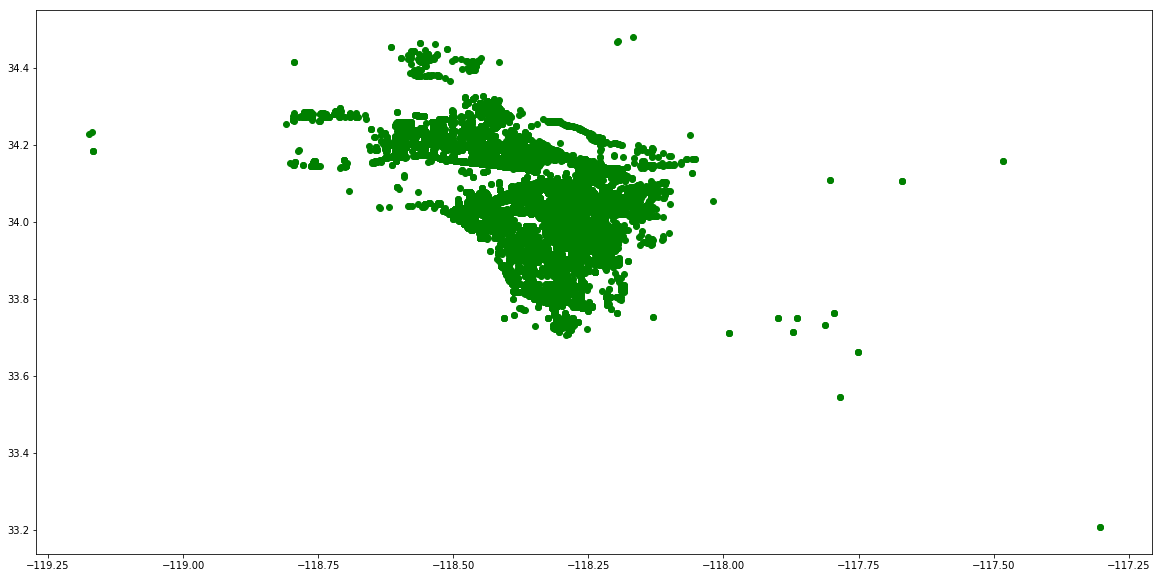

In [7]:
plt.figure(figsize=(20,10))
plt.scatter(yelp_df['longitude'], yelp_df['latitude'], color='g');

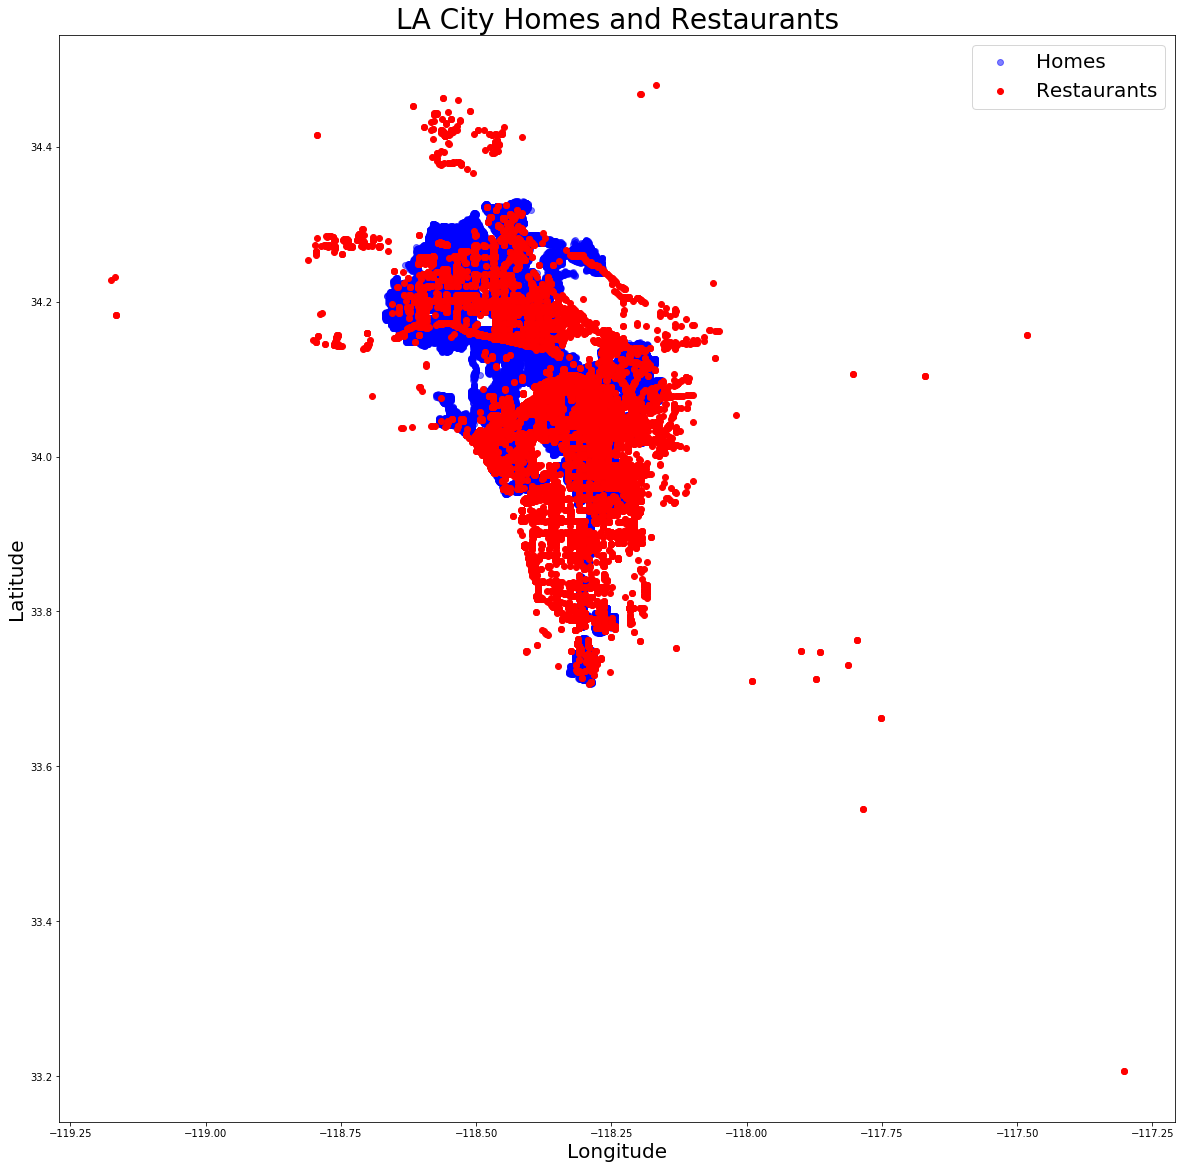

In [8]:
fig, ax = plt.subplots(figsize =(20,20))
ax.scatter(property_df['longitude'], property_df['latitude'], color='b', alpha=0.5, label='Homes')
plt.scatter(yelp_df['longitude'], yelp_df['latitude'], color='red', label='Restaurants')
plt.title('LA City Homes and Restaurants', fontsize=28)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
ax.legend(fontsize=20);

**Removing Restaurant Outliers**

- We created a mask to visualize our data better

- We further narrow down the restaurant samples to only zipcodes that exist in the property list

In [9]:
yelp_mask = yelp_df.drop(yelp_df[((yelp_df['longitude']>-118) & (yelp_df['latitude']<33.8))|
       ((yelp_df['longitude']<-118.7) & (yelp_df['latitude']>34.1))|
       ((yelp_df['longitude']<-118.2) & (yelp_df['latitude']>34.375))|
        (yelp_df['latitude']>34.35)|(yelp_df['longitude']>-118.05)|
        ((yelp_df['latitude']>33.375)&(yelp_df['longitude']>-118.15))|
        (yelp_df['latitude']>33.375)&(yelp_df['longitude']>-118.13)].index
)

In [10]:
yelp_mask.reset_index(drop=True, inplace = True)

In [11]:
yelp_mask.shape

(28373, 10)

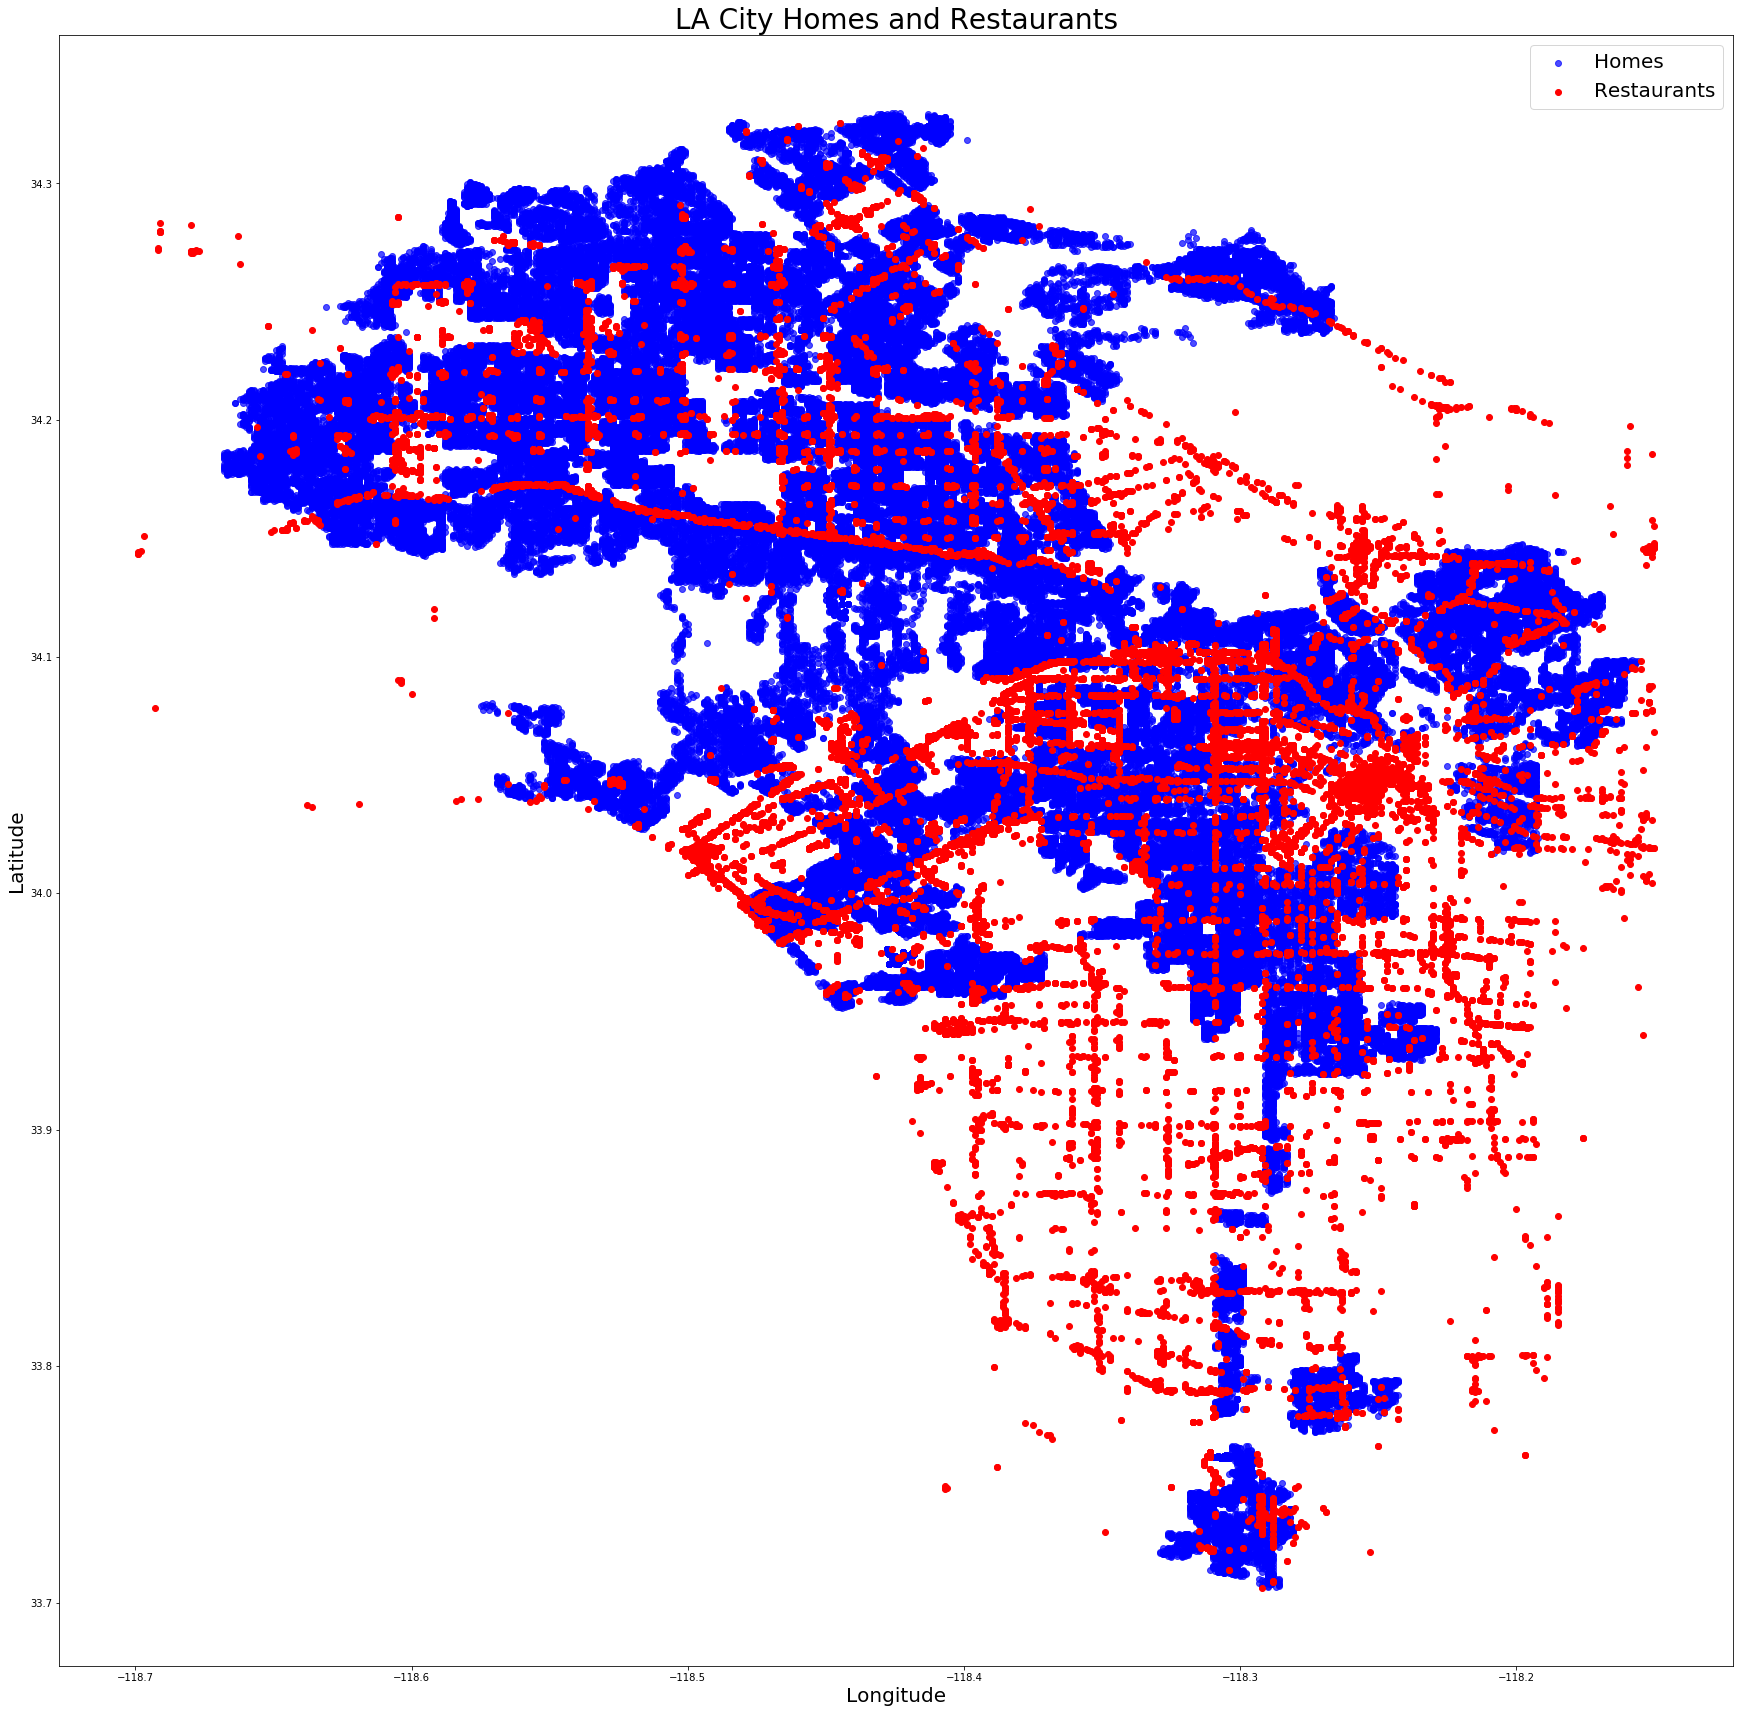

In [12]:
fig, ax = plt.subplots(figsize =(30,30))
ax.scatter(property_df['longitude'], property_df['latitude'], color='b', alpha=0.7, label='Homes')
plt.scatter(yelp_mask['longitude'], yelp_mask['latitude'], color='red', label='Restaurants')
plt.title('LA City Homes and Restaurants', fontsize=28)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
ax.legend(fontsize=20);

This list represents all the zipcodes of the Property samples

In [13]:
zip_code_list = [91342,91344,91335,91331,91326,91364,91306,91406,91343,91367,91304,90047,90045,90065,
                 90066,90042,90068,90049,90272,91604,90046,91307,91311,90731,91352,91605,91042,
                 91040,90044,91356,91423,90043,91325,90032,91401,91316,90064,91405,90016,91402,91436,91606,90026,90019,
                 90003,91403,90002,91324,90039,90291,90034,90041,91607,90744,90210,90027,90018,90011,90732,90077,90004,
                 90062,91345,90059,90008,90035,90037,91601,90069,91602,90036,90048,91411,90031, 
                 90024,91303,90710,90025,90014,90501,91340,90230,90247,90061,90293, 90023,90033,90094,90006,
                 90007,90292,90038,90001,90005,90029,90028,90063,90017,90248,90020,90402,90013,90012]

After filtering all restaurants in zipcodes that are shared with properties, we are left with approximately 22,000 restraurants. 

- Unfortunately, we do not have similar densities of restaurants in all regions (see the middle of the plot).

- The plot below represents all the restaurants over homes in a latitude and longitude range.

- We still have extreme outliers that will be dropped for the sake of KMeans clustering

In [14]:
yelp_df[yelp_df['zip'].isin(zip_code_list)].shape

(21753, 10)

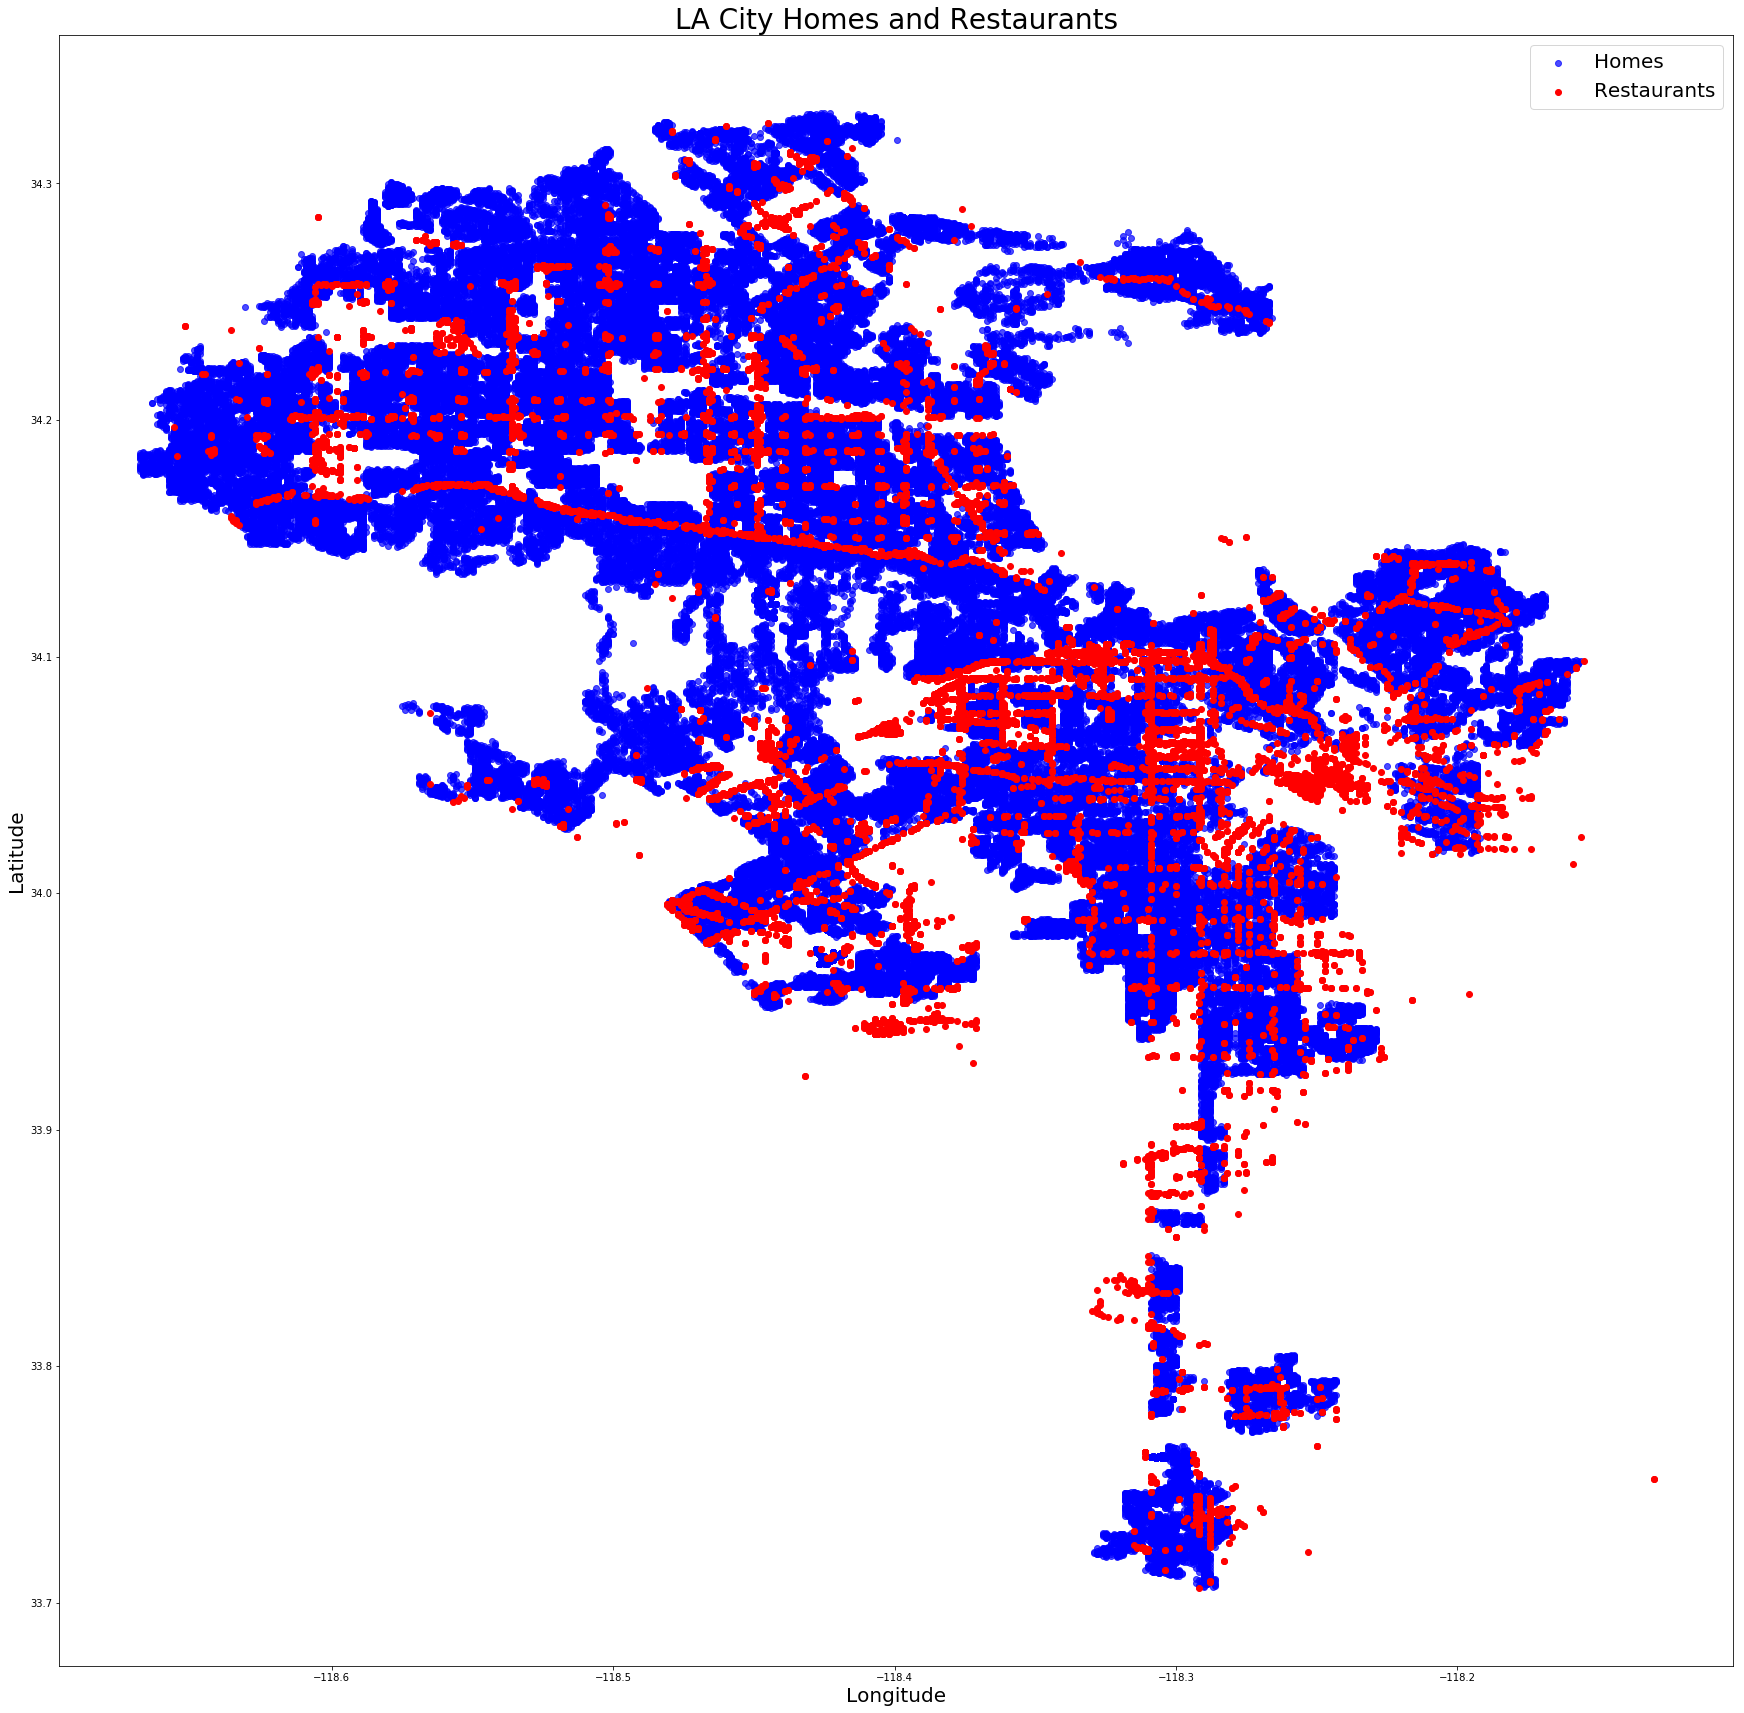

In [15]:
fig, ax = plt.subplots(figsize =(30,30))
ax.scatter(property_df['longitude'], property_df['latitude'], color='b', alpha=0.7, label='Homes')
plt.scatter(yelp_df['longitude'][yelp_df['zip'].isin(zip_code_list)]
            , yelp_df['latitude'][yelp_df['zip'].isin(zip_code_list)], color='red', label='Restaurants')
plt.title('LA City Homes and Restaurants', fontsize=28)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
ax.legend(fontsize=20);

In [16]:
yelp_property_zip = pd.DataFrame()
yelp_property_zip = yelp_df[yelp_df['zip'].isin(zip_code_list)]

In [17]:
yelp_property_zip[(yelp_property_zip['latitude']<33.8)&(yelp_property_zip['longitude']>-118.2)]

,name,id,price,alias,type,category,rating,zip,latitude,longitude
2643,Frijolito's Mobile Coffee,VkB0Cau98NFR75muz-uv5Q,1.0,frijolitos-mobile-coffee-los-angeles-4,coffee,coffee,4.5,90031,33.7523,-118.13
5393,Frijolito's Mobile Coffee,VkB0Cau98NFR75muz-uv5Q,1.0,frijolitos-mobile-coffee-los-angeles-4,coffee,coffee,4.5,90031,33.7523,-118.13


In [18]:
yelp_property_zip.drop(yelp_property_zip[
    (yelp_property_zip['latitude']<33.8)&(yelp_property_zip['longitude']>-118.2)].index, inplace=True)

C:\Users\seung\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
yelp_property_zip.reset_index(drop=True, inplace = True)

### KMeans Clustering ###

KMeans is a clustering algorithm seeks to create homogenous groups (similar latitude and longitude cooridinates). 

Each cluster, or group, will be mutual exclusive with no overlapping (properties or restaurants). Each group will have a center point (Centroid) and the goal is to split the data into a set that minimizes the total sum of square distances from each point(restaurant/property) from the Centroid.

The KMeans algorithm will use **Restaurants** to establish the clusters and the Properties will be assigned clusters based of their relative position to these clusers.

Since this Unsupervised learning, we cannot test for "correctness" of the model by feeding it a testing or validation set.


In [20]:
km = KMeans(n_clusters=103, random_state=42)

In [21]:
km.fit(yelp_property_zip[['latitude', 'longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=103, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

**Examining the 103 Clusters**

In the arrays below, the first array represents the clusters and the second array represents the count of restaurants in these clusters

In [22]:
np.unique(km.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102]),
 array([229,  69, 222, 775,  34,  85, 770, 242,  76, 228, 196, 199,  34,
        364, 211, 121, 308, 194, 149, 106, 402, 143, 394, 291, 180, 128,
        274, 364, 248, 382, 162,  75,  95, 161, 246,  35,  90, 153, 215,
        252, 250,  64, 341, 195, 178, 604, 113, 182, 136, 233, 250, 167,
        140, 302, 137, 220, 229, 176, 118, 271, 279, 201, 203,  30,  89,
        252, 271, 119, 301, 102, 155, 189, 119, 227, 1

### Evaluating Silhouette Score

Ideally, KMeans will create clusters that have low cohesion (average distance of sample points in a cluster) and high seperation between clusters.

A Silhouette Score evaluated these two traits. The score is between -1 and 1, with -1 being poor and 1 being optimal (for cohesion and seperation).

Another metric, Inertia, measure the sum of square errors for each cluster. We can modify this metric by increasing clusters. There is a point where adding clusters does not really help lowering inertia (low inertia is ideal). For our model, we picked 103 clusters to match up with the 103 zipcodes. If we went strictly off Inertia, 5 clusters is where the adding any more clusters does not really lower score.

In [23]:
silo_score = silhouette_score(yelp_property_zip[['latitude', 'longitude']], km.labels_)
print(silo_score)

0.4592412457905587


### Extracting Centroids of Clusters

We are extracting the Centroids established for the clusters as a DataFrame. We will need these points to measure property/restaurant distances from these points. 

We are using these distances as a proxy for distances of homes from restaurant "centers". Unfortunately, we do not have computations time nor the amount of rows to support up to 2.7 billion additional rows (total restaurant x total properties) or a home's distance from every restaurant in its cluster (too many features would be added).

In [24]:
km.cluster_centers_

array([[  34.05209039, -118.38320961],
       [  34.22775217, -118.50115942],
       [  33.78387207, -118.26571622],
       [  34.04791858, -118.25479097],
       [  34.04297059, -118.492     ],
       [  34.22269412, -118.36675294],
       [  34.10022623, -118.32981818],
       [  34.18658884, -118.60086777],
       [  33.93013947, -118.291     ],
       [  33.94332105, -118.40377632],
       [  34.1541199 , -118.47239796],
       [  34.04779246, -118.21109548],
       [  34.30886765, -118.46705882],
       [  34.08821511, -118.28118132],
       [  34.13574076, -118.21339336],
       [  34.01698595, -118.30752066],
       [  33.98806331, -118.44496104],
       [  34.17086289, -118.53864433],
       [  34.17067383, -118.40533557],
       [  34.22859245, -118.58400943],
       [  34.06474436, -118.29536275],
       [  34.01129091, -118.26229371],
       [  34.06172513, -118.4445203 ],
       [  34.01910412, -118.40945017],
       [  33.88051556, -118.30600556],
       [  34.27795938, -1

In [25]:
centroid_left, centroid_right = km.cluster_centers_[:, 0],km.cluster_centers_[:, 1]

In [26]:
centroid_df = pd.DataFrame(km.cluster_centers_, columns = ['latitude', 'longitude'])

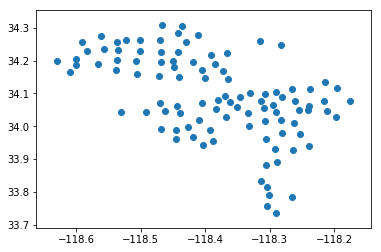

In [27]:
plt.scatter(centroid_right, centroid_left);

**Adding Cluster Labels to Yelp DataFrame**

This will help us group by clusters later.

In [28]:
yelp_property_zip['labels_km'] = km.labels_

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


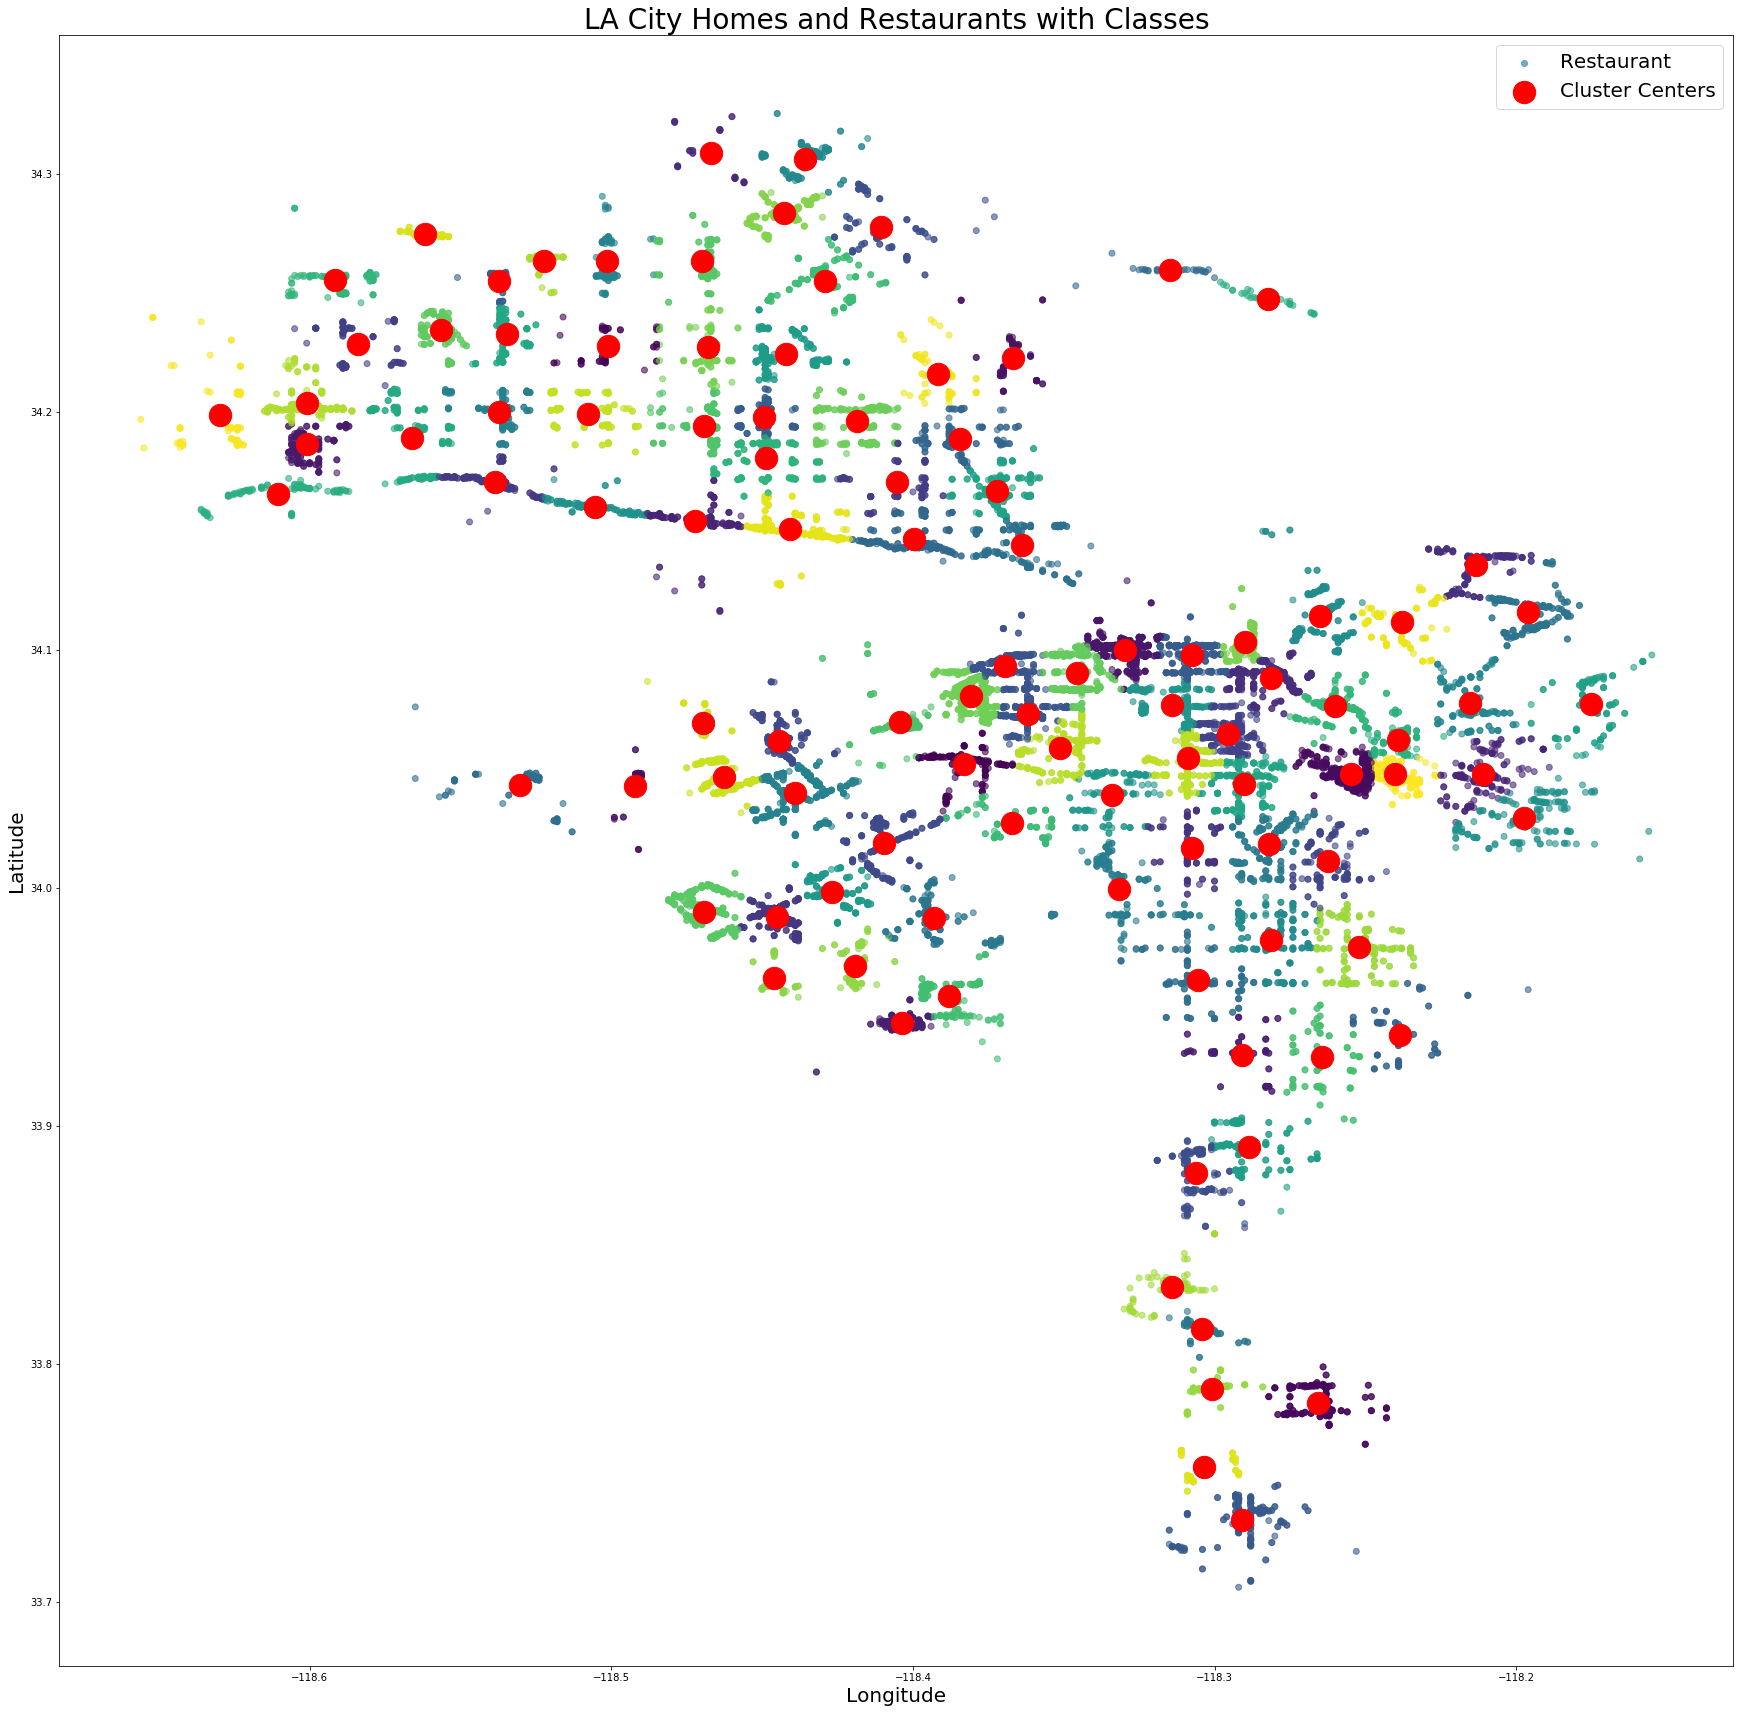

In [29]:
fig, ax = plt.subplots(figsize =(30,30))
ax.scatter(yelp_property_zip['longitude'], yelp_property_zip['latitude']
           , cmap='viridis', label='Restaurant', c=yelp_property_zip['labels_km'], alpha=0.6)
ax.scatter(centroid_right, centroid_left, color='red', label='Cluster Centers',s=500)

plt.title('LA City Homes and Restaurants with Classes', fontsize=28)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
ax.legend(fontsize=20);

### Using Established Clusters to Assign Clusters to Homes


Using KMeans model that fit clusters around the restaurants, the homes were assigned corresponding clusters based off its Longitude and Latitude cooridnates.

In [30]:
km.predict(property_df[['latitude', 'longitude']])

array([89, 89, 89, ..., 88, 88, 88])

In [31]:
np.unique(km.predict(property_df[['latitude', 'longitude']]), return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102]),
 array([1561, 1518, 1176,  907,  657, 1433, 1325,  450,  913,   29, 1958,
         441, 1312,  851, 1462, 1883, 1001, 2329, 1554, 1335,  120,  975,
         949, 1004,  150, 1564, 1812,  749, 2016,  559, 1037,  803, 1372,
        1057, 2135, 2017, 1934, 2611, 2063, 2434,  538,  285,  256, 2344,
        1811, 1440, 2445,  967, 1856, 1866, 1118,  457, 1699,  991, 1417,
        1450, 1795,  386, 1532, 1000,  331, 1029,

In [32]:
silhouette_score(property_df[['latitude', 'longitude']], km.predict(property_df[['latitude', 'longitude']]))

In [35]:
property_df['labels_km'] = km.predict(property_df[['latitude', 'longitude']])

**Visualing Restaurants, Homes, and Centroids**

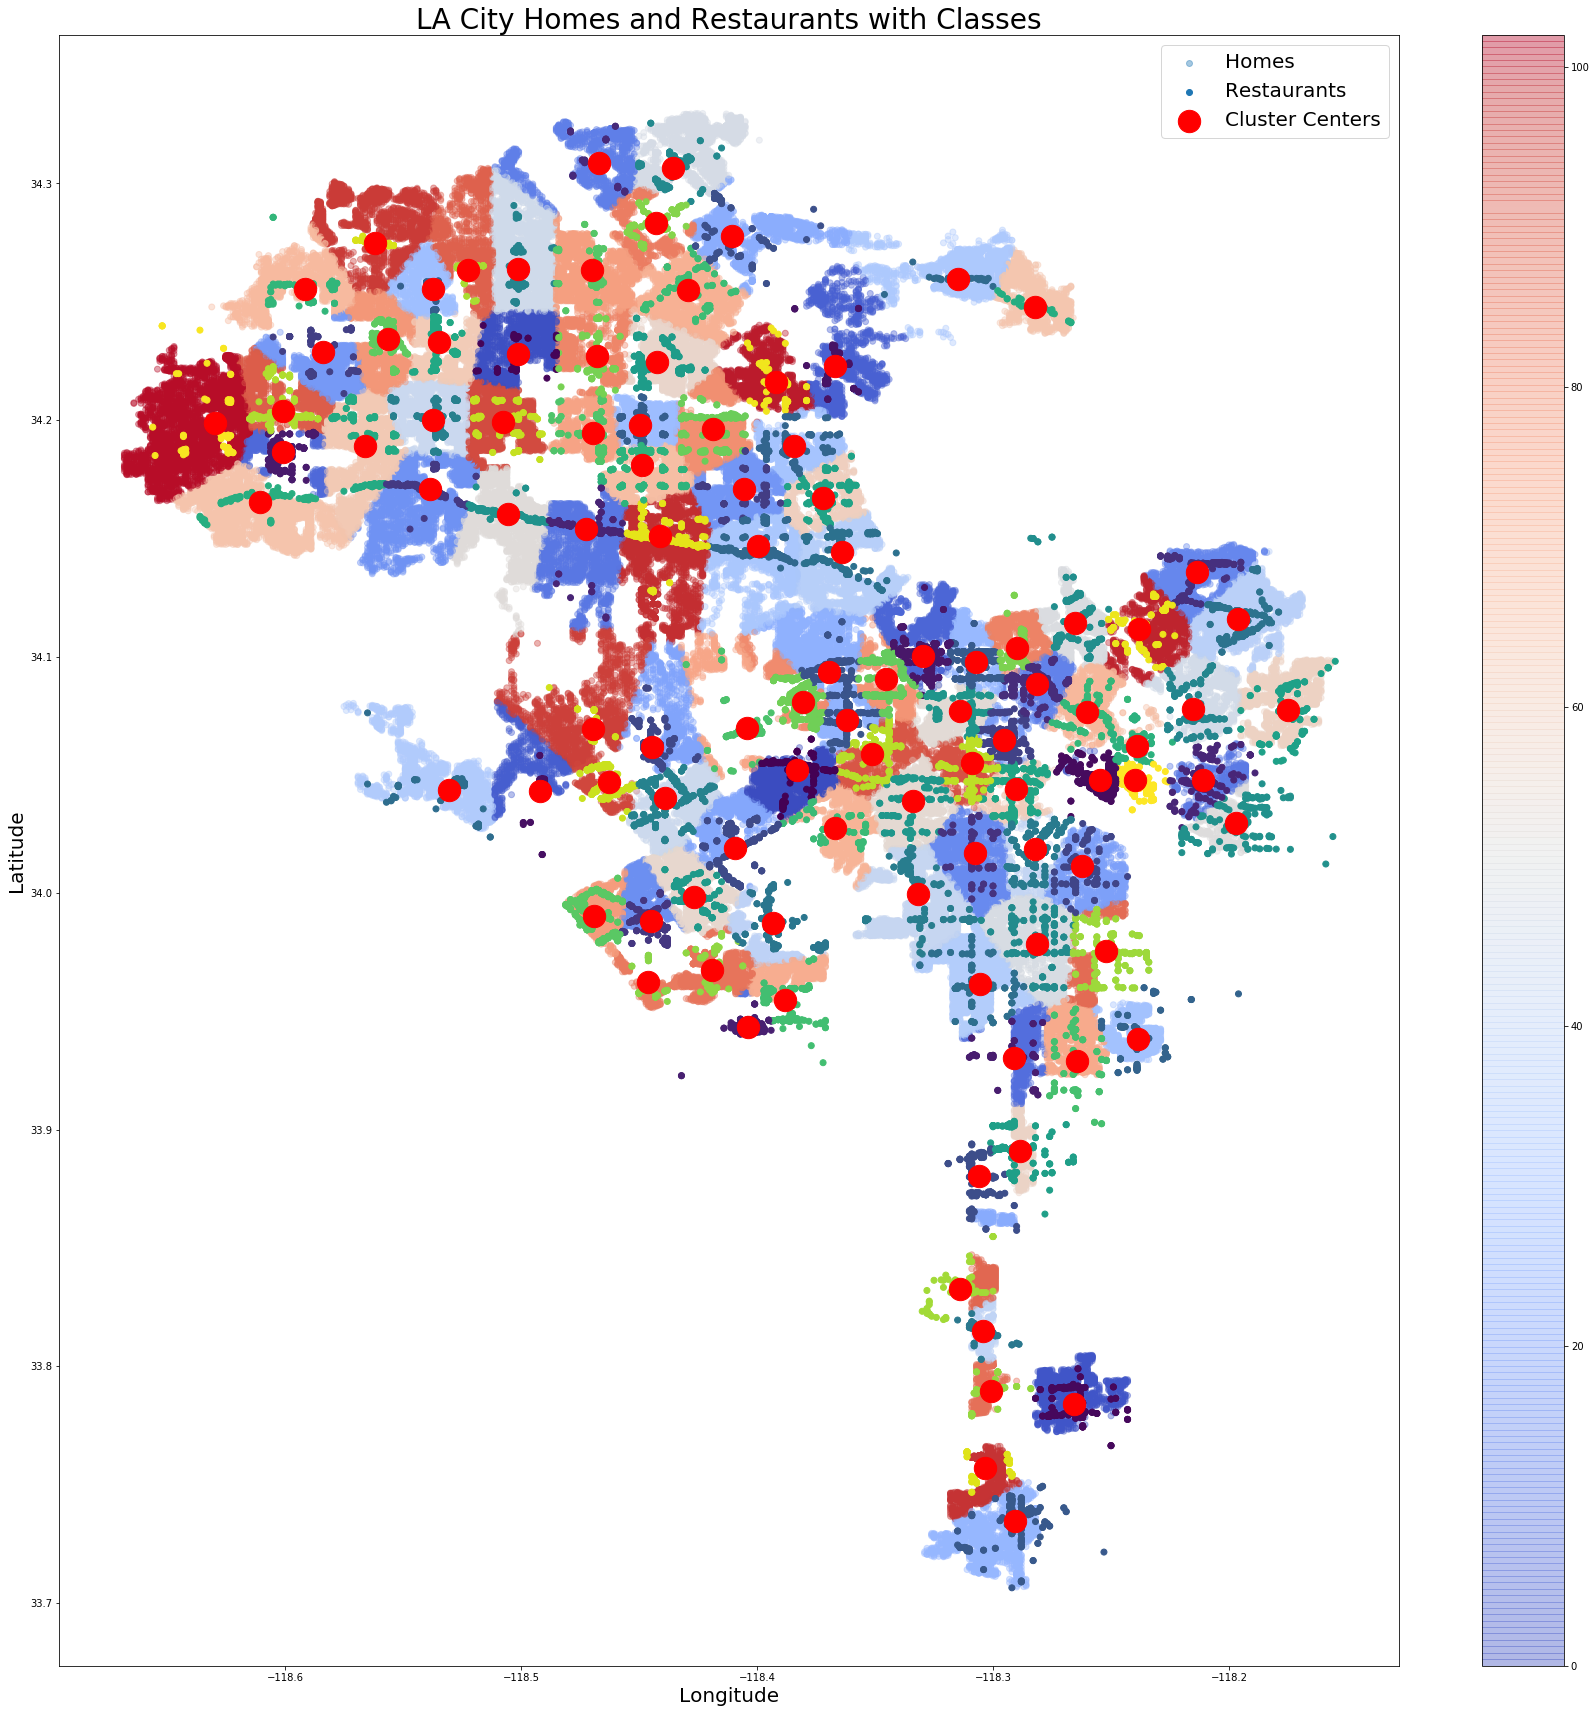

In [64]:

fig, ax = plt.subplots(figsize =(30,30))
plt.scatter(property_df['longitude'], property_df['latitude']
           , cmap='coolwarm', label='Homes', c=property_df['labels_km'], alpha=0.4)
ax.scatter(yelp_property_zip['longitude'], yelp_property_zip['latitude'],
           cmap= 'viridis',c=yelp_property_zip['labels_km'], label='Restaurants')
ax.scatter(centroid_right, centroid_left, color='red', label='Cluster Centers',s=500)

plt.title('LA City Homes and Restaurants with Classes', fontsize=28)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
plt.colorbar(ax=ax)
ax.legend(fontsize=20)
plt.savefig('./data/cluster.png', bbox_inches='tight');

**Attaching Centroid Latitude and Longitude to DataFrames**

Adding these cooridinates, we will calculate the distance of each restaurant and home from the center of the cluster.

In [37]:
yelp_property_zip['centroid_latitude'] = yelp_property_zip['labels_km'].map(lambda x: centroid_df.loc[x, 'latitude'])

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
yelp_property_zip['centroid_longitude'] = yelp_property_zip['labels_km'].map(lambda x: centroid_df.loc[x, 'longitude'])

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
property_df['centroid_latitude'] = property_df['labels_km'].map(lambda x: centroid_df.loc[x, 'latitude'])

In [40]:
property_df['centroid_longitude'] = property_df['labels_km'].map(lambda x: centroid_df.loc[x, 'longitude'])

In [62]:
property_df[property_df.labels_km == 78]['zip'].value_counts()

90046    289
90036    197
90038    124
90004    100
90028     23
90068     18
Name: zip, dtype: int64

This formula is to calcualate the paired distance (matrice cosin distance) of each sample to the Centroid. We are using this as a feature to evaluate in our Supervised Models.

We are noticing a 0.1% error from the calculation of euclidean distance calculation. we are attributing this to float rounding error. the error at that rate will be noted but not make a huge impact on calculation.

In [42]:
def latlongdistance(row):
    X = [[row['centroid_longitude'], row['centroid_latitude']]]
    y = [[row['longitude'], row['latitude']]]
    
    return round(paired_distances(X, y)[0], 6)



In [43]:
property_df['distance_centroid'] = property_df.apply(latlongdistance, axis=1)

In [44]:
property_df[['distance_centroid']].head(10)

,distance_centroid
0,0.025305
1,0.024465
2,0.023853
3,0.023261
4,0.022760
5,0.023496
6,0.023658
7,0.024331
8,0.024411
9,0.024014


In [45]:
yelp_property_zip['distance_centroid'] = yelp_property_zip.apply(latlongdistance, axis=1)

C:\Users\seung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
yelp_property_zip[['distance_centroid']].head()

,distance_centroid
0,0.007704
1,0.003238
2,0.031590
3,0.037774
4,0.031762


In [47]:
yelp_property_zip.to_csv('./data/yelp_final_df_150.csv', header=yelp_property_zip.columns)

In [48]:
property_df.to_csv('./data/property_final_df_labeled_150.csv', header=property_df.columns)